## OpenAI-to-Z Challenge – Checkpoint 1

**Goals for this notebook**
1. Make sure Python, key libraries and your API credentials are configured.
2. Explain – and briefly demonstrate – programme-matic access to
    * OpenTopography LiDAR / global DEM data
    * Sentinel-2 multispectral imagery
3. Pull one small raster tile from either service (here we use an SRTM DEM via the OpenTopography GlobalDEM API because it is tiny and unauthenticated), show it on a map, and run a single OpenAI multimodal model on it.

In [24]:
import os
import json
import time
import pathlib
from datetime import datetime, timezone

import requests
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from openai import OpenAI
import subprocess

In [26]:
CONFIG = {
    "LOG_PATH": pathlib.Path("openai_log.jsonl"),
    "MODEL_NAME": 'o4-mini',
    "OPENAI_API_KEY": os.getenv("OPENAI_API_KEY_openai_to_z"),
    "OPENTOPOGRAPHY_API_KEY": os.getenv('OPENTOPOGRAPHY_API_KEY'),
    "MODEL_COSTS": {
        # dollars per 1 000 000 tokens, **exactly as shown on the pricing page**
        "gpt-4.1":       {"in": 2.00,  "out": 8.00},
        "gpt-4.1-mini":  {"in": 0.40,  "out": 1.60},
        "gpt-4.1-nano":  {"in": 0.10,  "out": 0.40},
        "o3":            {"in":10.00,  "out":40.00},
        "o4-mini":       {"in": 1.10,  "out": 4.40},
        "gpt-4o":        {"in": 5.00,  "out":20.00},
        "gpt-4o-mini":   {"in": 0.60,  "out": 2.40}
    }
}

if CONFIG["OPENTOPOGRAPHY_API_KEY"] is None:
    raise RuntimeError("OPENTOPOGRAPHY_API_KEY not set in the environment")

In [27]:
def get_cost(
        model,
        prompt_tokens,
        completion_tokens
):
    price = CONFIG["MODEL_COSTS"].get(model)
    cost = (prompt_tokens / 1_000_000) * price["in"] + \
           (completion_tokens / 1_000_000) * price["out"]
    return cost

In [28]:
def log_interaction(
    model: str,
    prompt_text: str,
    response_text: str,
    prompt_tokens: int,
    completion_tokens: int,
    prompt_time: None
) -> float:
    """
    Append a JSONL record and return the cost in USD.
    """
    cost = get_cost(model, prompt_tokens, completion_tokens)
    
    prompt_time = datetime.now(timezone.utc).isoformat(timespec="seconds") if prompt_time is None else prompt_time
    entry = {
        "utc_time": prompt_time,
        "model": model,                 # keep the full versioned name
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "cost_usd": round(cost, 6),
        "prompt_text": prompt_text,
        "response_text": response_text,
    }

    CONFIG["LOG_PATH"].parent.mkdir(parents=True, exist_ok=True)
    with CONFIG["LOG_PATH"].open("a", encoding="utf-8") as fp:
        json.dump(entry, fp)
        fp.write("\n")

    return None

In [63]:
# download 0.1 x 0.1 degree window over Yosemite Valley

lat, lon = 53.48, -2.24

CONFIG_DATA = {
    "DEM_TYPE": "SRTMGL1",
    "OUT_FMT": "GTiff",
    "LOCATION_ROUGH": "Manchester",
    "BBOX": {
        "south":    lat-0.2,
        "north":    lat+0.2,
        "west":     lon-0.2,
        "east":     lon+0.2
    },
    "BASE_URL": "https://portal.opentopography.org/API/globaldem"
}
CONFIG_DATA["DEM_PATH"] = pathlib.Path(f"{CONFIG_DATA['LOCATION_ROUGH']}_dem.tif")

params = {
    "demtype": CONFIG_DATA["DEM_TYPE"],
    "south":   CONFIG_DATA["BBOX"]["south"],
    "north":   CONFIG_DATA["BBOX"]["north"],
    "west":    CONFIG_DATA["BBOX"]["west"],
    "east":    CONFIG_DATA["BBOX"]["east"],
    "outputFormat": CONFIG_DATA["OUT_FMT"],
    "API_Key": CONFIG["OPENTOPOGRAPHY_API_KEY"]
}

# base_url = "https://portal.opentopography.org/API/globaldem"
# dem_path = pathlib.Path(f"{CONFIG_DATA['LOCATION_ROUGH']}_dem.tif")

if not CONFIG_DATA["DEM_PATH"].exists():
    r = requests.get(CONFIG_DATA["BASE_URL"], params=params, timeout=120)
    r.raise_for_status()
    CONFIG_DATA["DEM_PATH"].write_bytes(r.content)
    print(f"Downloaded {CONFIG_DATA["DEM_PATH"]} ({CONFIG_DATA["DEM_PATH"].stat().st_size/1024:.1f} KB)")
else:
    print(f"Using cached {CONFIG_DATA["DEM_PATH"]}")

Downloaded Manchester_dem.tif (1308.5 KB)


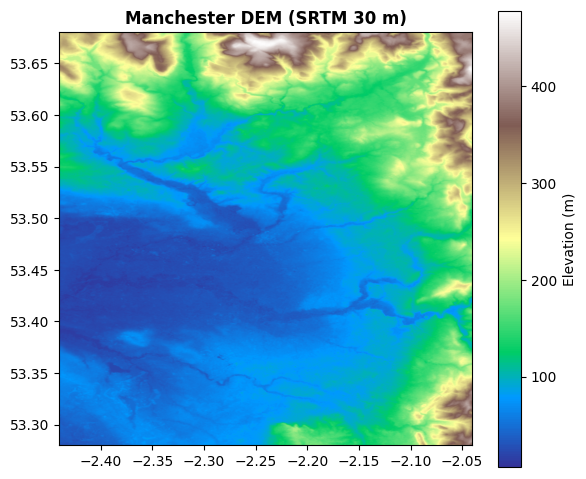

In [64]:
with rasterio.open(CONFIG_DATA["DEM_PATH"]) as src:
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # plot the DEM with a terrain colour-map
    img = show(src, ax=ax,
               title=f"{CONFIG_DATA['LOCATION_ROUGH']} DEM (SRTM 30 m)", cmap="terrain"
    )

    # show(src, ax=ax, cmap="terrain", title="Yosemite DEM (SRTM 30 m)")

    im = ax.images[0]

    fig.colorbar(im, ax=ax, shrink=0.8, label="Elevation (m)")
    
    plt.tight_layout()

    plt.show()

In [65]:
# Prepare a tiny prompt
with rasterio.open(CONFIG_DATA["DEM_PATH"]) as src:
    data = src.read(1, masked=True)
    mean_elev = float(data.mean())
    std_elev = float(data.std())
    prompt = (
        f"Here are simple stats from a 30 m DEM tile extracted from OpenTopography (dataset={CONFIG_DATA["DEM_TYPE"]}). Mean elevation: {mean_elev:.1f} m asl; standard deviation: {std_elev:.1f} m. In plain English several paragraphs, summarise the likely landscape processes shaping this terrain and mention the dominant relief. Suggest where this might be from. Explain the data source and the landscape."
    )

print(prompt)

Here are simple stats from a 30 m DEM tile extracted from OpenTopography (dataset=SRTMGL1). Mean elevation: 121.8 m asl; standard deviation: 90.6 m. In plain English several paragraphs, summarise the likely landscape processes shaping this terrain and mention the dominant relief. Suggest where this might be from. Explain the data source and the landscape.


In [66]:
client = OpenAI(
    api_key = CONFIG["OPENAI_API_KEY"]
)
response = client.chat.completions.create(
    model=CONFIG["MODEL_NAME"],
    messages=[{"role": "user", "content": prompt}],
)
prompt_time = datetime.now(timezone.utc).isoformat(timespec="seconds")


In [67]:
msg = response.choices[0].message.content

log_interaction(
    model=CONFIG["MODEL_NAME"],
    prompt_text=prompt,
    response_text=msg,
    prompt_tokens=response.usage.prompt_tokens,
    completion_tokens=response.usage.completion_tokens,
    prompt_time=prompt_time
)

session_cost = get_cost(
    CONFIG["MODEL_NAME"],
    response.usage.prompt_tokens,
    response.usage.completion_tokens
    )

print(f"⇢ Tokens {response.usage.prompt_tokens}/{response.usage.completion_tokens} "
      f"| Cost ${session_cost:.4f}")

print("---")
print(response.choices[0].message.content)
model_version = response.model            # the library echoes back the name you used
dataset_id    = params["demtype"]         # or your own 'scene_id' / LAS name

print("---")
print(f"Model: {model_version}")
print(f"Dataset ID: {dataset_id}")

⇢ Tokens 85/2154 | Cost $0.0096
---
You’ve taken a 30 m‐resolution digital elevation model (DEM) from the SRTMGL1 product via OpenTopography and calculated two quick summary numbers: an average elevation of about 122 m above sea level, and a standard deviation of roughly 91 m.  In everyday language, what does that tell us about the kind of ground we’re looking at—and how it got that way?

First, the mean of 122 m asl means this isn’t a high-mountain landscape, nor is it sea-level flat.  It sits hundreds of feet above the shore, but well below true alpine country.  The relatively large spread—roughly ±90 m—means that within this tile you’re seeing hills, valleys, ridges or plateaus that vary by a couple of hundred metres in height from the lowest point to the highest.  In other words, you aren’t looking at a smooth plain or an abrupt cliff face, but a moderately dissected hilly terrain.

Second, what processes carve out a landscape like this?  A standard deviation near 90 m suggests sig